   # Taxi-Out Prediction

### Description of the columns

There are $28820$ observations of $23$ variables.
Each observation is an individual flight.
- `MONTH`, `DAY_OF_MONTH`, `DAY_OF_WEEK` contain information about the date of the flight
- `OP_UNIQUE_CARRIER` contains ID of the airline (i.e. `AA` stands for American Airlines)
- `TAIL_NUM` is the tail number of the plane
- `DEST` is the destination airport code
- `DEP_DELAY` is the departure delay of the flight
- `CRS_ELAPSED_TIME` is expected duration of the light
- `DISTANCE` is the distance between airports
- `CRS_DEP_M` is scheduled departure time (in minutes after midnight)
- `DEP_TIME_M` is actual departure time (gate checkout)
- `CRS_ARR_M` is scheduled arrival time
- `Temperature`, `Dew Point`, `Humidity`, `Wind Speed`, `Wind Gust` and `Pressure` are the numeric characteristis of the weather
- `Wind` is the direction of the wind (`CALM` if calm, `VAR` if wind blows from various directions)
- `Condition` contains natural language description of the weather
- `sch_dep` is the number of flights scheduled for departure
- `sch_arr` is the number of flights scheduled for arrival 
- `TAXI_OUT` is the time between the actual pushback and wheels-off.

There are five caterogical variables: `OP_UNIQUE_CARRIER`, `TAIL_NUM`, `DEST`, `WIND` and `Condition`. 
The rest of the variables is numerical.


Our target variable is `TAXI_OUT`.


In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore

In [192]:
df = pd.read_csv('M1_final.csv')

## DATA CLEANING

#### Renaming the columns for better understanding:-

In [193]:
column_names={"OP_UNIQUE_CARRIER":"CARRIER_CODE",
                "CRS_ELAPSED_TIME":"SCHEDULED_DURATION",
                "CRS_DEP_M":"SCHEDULED_DEPARTURE",
                "DEP_TIME_M":"ACTUAL_DEPATURE",
                "CRS_ARR_M":"SCHEDULED_ARRIVAL",
                "sch_dep":"FLT_SCH_DEPATURE",
                "sch_arr":"FLT_SCH_ARRIVAL"
               }

df = df.rename(column_names, axis=1)

#### Dropping unnecessary features:-

Dropping TAIL_NUM as it act as a unique identifier and dosen't help the model for prediction

In [194]:
df=df.drop('TAIL_NUM',axis=1) 

Dropping MONTH as it holds only 11, 12,  1 and it is not going to help the model for prediction

In [195]:
df['MONTH'].unique()

array([11, 12,  1], dtype=int64)

In [196]:
df=df.drop('MONTH',axis=1)

Dropping the DAY_OF_MONTH for the same a above reason:-

In [197]:
df.DAY_OF_MONTH.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

In [198]:
df=df.drop('DAY_OF_MONTH',axis=1)

#### Dew point feature | Cleaning 

In [199]:
df['Dew Point'].unique()

array(['34', '32', '33', '31', '30', '29', '67', '35', '36', '38', '39',
       '40', '41', '42', '28', '27', '46', '37', '44', '45', '52', '53',
       '54', '56', '57', '59', '58', '50', '43', '48', '49', '47', '21',
       '20', '22', '24', '23', '19', '18', '16', '13', '12', '14', '15',
       '17', '26', '25', '51', '55', '6\xa0', '9\xa0', '5\xa0', '8\xa0',
       '10', '4\xa0', '7\xa0', '3\xa0', '2\xa0', '11', '0\xa0', '-1',
       '1\xa0', '-2', '-3'], dtype=object)

In [200]:
df['Dew Point'].replace(u'\xa0',u'', regex=True, inplace=True)

In [201]:
df['Dew Point'].unique()

array(['34', '32', '33', '31', '30', '29', '67', '35', '36', '38', '39',
       '40', '41', '42', '28', '27', '46', '37', '44', '45', '52', '53',
       '54', '56', '57', '59', '58', '50', '43', '48', '49', '47', '21',
       '20', '22', '24', '23', '19', '18', '16', '13', '12', '14', '15',
       '17', '26', '25', '51', '55', '6', '9', '5', '8', '10', '4', '7',
       '3', '2', '11', '0', '-1', '1', '-2', '-3'], dtype=object)

In [202]:
df['Dew Point'] = df['Dew Point'].astype('int64')

<AxesSubplot:xlabel='Dew Point'>

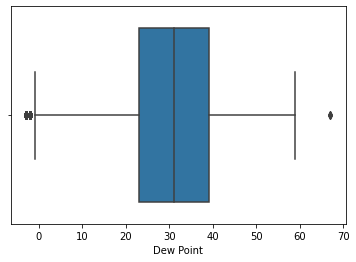

In [203]:
sns.boxplot(x=df['Dew Point'])

In [204]:
# Visualization shows the presence of extreme values 

####  Wind feature | clubbing into 6 main categories

In [205]:
df['Wind'].value_counts()

W       3273
NW      3173
NNW     2570
WSW     2567
N       2453
SW      2354
WNW     2145
S       1879
SSW     1632
NNE     1280
ENE     1124
E       1068
NE      1044
CALM     835
ESE      466
SE       345
SSE      315
VAR      295
Name: Wind, dtype: int64

In [206]:
df['Wind'] = df['Wind'].str[0]

In [207]:
df['Wind'].unique()

array(['W', 'N', 'S', 'E', 'C', 'V', nan], dtype=object)

In [208]:
df['Wind'].value_counts()

N    10520
W     7985
S     6525
E     2658
C      835
V      295
Name: Wind, dtype: int64

#### DAY_OF_WEEK feature | numerical to categorical

In [209]:
df.DAY_OF_WEEK.unique()

array([5, 6, 7, 1, 2, 3, 4], dtype=int64)

In [210]:
df.DAY_OF_WEEK.value_counts()

5    4708
7    4150
4    4135
2    4065
1    4051
3    4013
6    3698
Name: DAY_OF_WEEK, dtype: int64

In [211]:
df['DAY_OF_WEEK']=df['DAY_OF_WEEK'].astype('object')

#### SCHEDULED_DEPARTURE feature | Bin Creation

In [212]:
df['SCHEDULED_DEPARTURE'] = pd.cut(df['SCHEDULED_DEPARTURE'],
                                   bins=[0,180,720,1020,1200,1440],
                                   labels=['Midnight','Morning','Noon','Evening','Night'])

In [213]:
df['SCHEDULED_DEPARTURE']=df['SCHEDULED_DEPARTURE'].astype('object')

In [214]:
df.SCHEDULED_DEPARTURE.value_counts()

Morning    11917
Noon        8287
Evening     4991
Night       3625
Name: SCHEDULED_DEPARTURE, dtype: int64

#### ACTUAL_DEPATURE feature | Bin Creation

In [215]:
df['ACTUAL_DEPATURE'] = pd.cut(df['ACTUAL_DEPATURE'],
                               bins=[0,180,720,1020,1200,1440],
                               labels=['Midnight','Morning','Noon','Evening','Night'])

In [216]:
df['ACTUAL_DEPATURE']=df['ACTUAL_DEPATURE'].astype('object')

In [217]:
df.ACTUAL_DEPATURE.value_counts()

Morning     11831
Noon         8061
Evening      4965
Night        3821
Midnight      142
Name: ACTUAL_DEPATURE, dtype: int64

#### SCHEDULED_ARRIVAL feature | Bin Creation

In [218]:
df['SCHEDULED_ARRIVAL'] = pd.cut(df['SCHEDULED_ARRIVAL'],
                                 bins=[0,180,720,1020,1200,1440],
                                 labels=['Midnight','Morning','Noon','Evening','Night'])

In [219]:
df['SCHEDULED_ARRIVAL']=df['SCHEDULED_ARRIVAL'].astype('object')

In [220]:
df.SCHEDULED_ARRIVAL.value_counts()

Morning     7713
Noon        7317
Night       7090
Evening     5169
Midnight    1531
Name: SCHEDULED_ARRIVAL, dtype: int64

#### SPEED feature | New feature creation (Diatance/ time = speed)

In [221]:
df['DISTANCE']=df['DISTANCE']*1.60934  #Converting miles into Kilo metres

In [222]:
df['SCHEDULED_DURATION']=df['SCHEDULED_DURATION'] / 60    #Coverting scheduled duration into hours

In [223]:
df['SPEED']=df['DISTANCE'] / df['SCHEDULED_DURATION']  #Calc.Speed in Km per Hour

<AxesSubplot:xlabel='SPEED'>

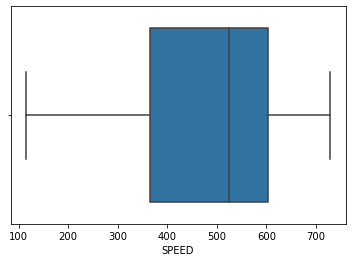

In [224]:
sns.boxplot(df['SPEED'])

-0.5665480389721033


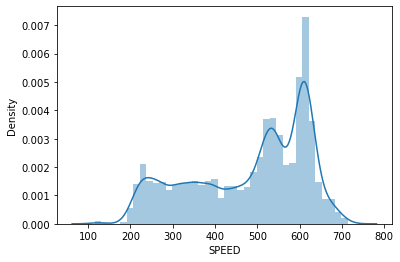

In [225]:
sns.distplot(df['SPEED'])
print(df['SPEED'].skew())

#### Region feature | New feature creation 

- Created with the help of DEST feature
- Combined the destination into groups based on political Map

In [226]:
df['DEST'].unique()

array(['CHS', 'LAX', 'FLL', 'MCO', 'ATL', 'ORD', 'BUF', 'LGB', 'LAS',
       'DCA', 'PHX', 'SFO', 'SJU', 'SLC', 'BOS', 'SAV', 'SYR', 'MSP',
       'SEA', 'MIA', 'PDX', 'TPA', 'BTV', 'IAH', 'DEN', 'RSW', 'ORF',
       'JAX', 'MSY', 'CLT', 'BNA', 'RDU', 'SAN', 'SJC', 'ROC', 'DFW',
       'IAD', 'AUS', 'DTW', 'PWM', 'SRQ', 'CMH', 'HNL', 'PBI', 'BWI',
       'CLE', 'BUR', 'PIT', 'RIC', 'IND', 'CVG', 'SMF', 'ONT', 'SAT',
       'PSP', 'OAK', 'ABQ', 'PSE', 'ORH', 'BQN', 'STT', 'RNO', 'PHL',
       'EGE', 'JAC'], dtype=object)

In [227]:
df['Region']=np.nan

In [228]:
df.loc[df['DEST']=='BOS', 'Region'] ='North East'
df.loc[df['DEST']=='BTV', 'Region'] ='North East'
df.loc[df['DEST']=='BUF', 'Region'] ='North East'
df.loc[df['DEST']=='ORH', 'Region'] ='North East'
df.loc[df['DEST']=='PHL', 'Region'] ='North East'
df.loc[df['DEST']=='PIT', 'Region'] ='North East'
df.loc[df['DEST']=='ROC', 'Region'] ='North East'
df.loc[df['DEST']=='SYR', 'Region'] ='North East'
df.loc[df['DEST']=='ATL', 'Region'] ='South'
df.loc[df['DEST']=='AUS', 'Region'] ='South'
df.loc[df['DEST']=='BNA', 'Region'] ='South'
df.loc[df['DEST']=='BQN', 'Region'] ='South'
df.loc[df['DEST']=='CHS', 'Region'] ='South'
df.loc[df['DEST']=='CLT', 'Region'] ='South'
df.loc[df['DEST']=='DTW', 'Region'] ='South'
df.loc[df['DEST']=='FLL', 'Region'] ='South'
df.loc[df['DEST']=='HNL', 'Region'] ='South'
df.loc[df['DEST']=='IAH', 'Region'] ='South'
df.loc[df['DEST']=='JAC', 'Region'] ='South'
df.loc[df['DEST']=='JAX', 'Region'] ='South'
df.loc[df['DEST']=='MCO', 'Region'] ='South'
df.loc[df['DEST']=='MIA', 'Region'] ='South'
df.loc[df['DEST']=='MSY', 'Region'] ='South'
df.loc[df['DEST']=='PBI', 'Region'] ='South'
df.loc[df['DEST']=='PSE', 'Region'] ='South'
df.loc[df['DEST']=='RIC', 'Region'] ='South'
df.loc[df['DEST']=='RSW', 'Region'] ='South'
df.loc[df['DEST']=='SAT', 'Region'] ='South'
df.loc[df['DEST']=='SAV', 'Region'] ='South'
df.loc[df['DEST']=='SRQ', 'Region'] ='South'
df.loc[df['DEST']=='STT', 'Region'] ='South'
df.loc[df['DEST']=='TPA', 'Region'] ='South'

df.loc[df['DEST']=='CLE', 'Region'] ='Mid West'
df.loc[df['DEST']=='CMH', 'Region'] ='Mid West'
df.loc[df['DEST']=='CVG', 'Region'] ='Mid West'
df.loc[df['DEST']=='DFW', 'Region'] ='Mid West'
df.loc[df['DEST']=='IND', 'Region'] ='Mid West'
df.loc[df['DEST']=='MSP', 'Region'] ='Mid West'
df.loc[df['DEST']=='ORD', 'Region'] ='Mid West'
df.loc[df['DEST']=='ORF', 'Region'] ='Mid West'

df.loc[df['DEST']=='ABQ', 'Region'] ='West'
df.loc[df['DEST']=='BUR', 'Region'] ='West'
df.loc[df['DEST']=='BWI', 'Region'] ='West'
df.loc[df['DEST']=='DCA', 'Region'] ='West'
df.loc[df['DEST']=='DEN', 'Region'] ='West'
df.loc[df['DEST']=='EGE', 'Region'] ='West'
df.loc[df['DEST']=='IAD', 'Region'] ='West'
df.loc[df['DEST']=='LAS', 'Region'] ='West'
df.loc[df['DEST']=='LAX', 'Region'] ='West'
df.loc[df['DEST']=='LGB', 'Region'] ='West'
df.loc[df['DEST']=='ONT', 'Region'] ='West'
df.loc[df['DEST']=='OAK', 'Region'] ='West'
df.loc[df['DEST']=='PDX', 'Region'] ='West'
df.loc[df['DEST']=='PHX', 'Region'] ='West'
df.loc[df['DEST']=='PSP', 'Region'] ='West'
df.loc[df['DEST']=='PWM', 'Region'] ='West'
df.loc[df['DEST']=='RDU', 'Region'] ='West'
df.loc[df['DEST']=='RNO', 'Region'] ='West'
df.loc[df['DEST']=='SAN', 'Region'] ='West'
df.loc[df['DEST']=='SEA', 'Region'] ='West'
df.loc[df['DEST']=='SFO', 'Region'] ='West'
df.loc[df['DEST']=='SJC', 'Region'] ='West'
df.loc[df['DEST']=='SJU', 'Region'] ='West'
df.loc[df['DEST']=='SLC', 'Region'] ='West'
df.loc[df['DEST']=='SMF', 'Region'] ='West'


In [229]:
df['Region'].value_counts()

West          12128
South          9899
North East     3979
Mid West       2814
Name: Region, dtype: int64

#### DEP_DELAY | New Feature Creation

- created by seperating DEP DELAY into 3 bins (Early, Ontime, Delayed)

In [230]:
df['DEP_DELAY'] = pd.cut(df['DEP_DELAY'],
                           bins=[-22,-1,0,1276],
                           labels=['EARLY','ONTIME','DELAYED'])

In [231]:
df['DEP_DELAY'].value_counts(normalize=True)

EARLY      0.678303
DELAYED    0.270828
ONTIME     0.050869
Name: DEP_DELAY, dtype: float64

In [232]:
df['DEP_DELAY']=df['DEP_DELAY'].astype('object')

#### TOTAL_SCHEDULED | Feature Creation

In [233]:
df["TOTAL_SCHEDULED"] = df["FLT_SCH_DEPATURE"] + df["FLT_SCH_ARRIVAL"]
df["TOTAL_SCHEDULED"].value_counts(ascending = True)

2        2
9        2
18       3
8        4
17       4
      ... 
70    1156
67    1296
66    1328
64    1391
68    1494
Name: TOTAL_SCHEDULED, Length: 73, dtype: int64

#### FLIGHT_TRAFFIC | Feature Creation

In [234]:
df["FLIGHT_TRAFFIC"] = pd.cut(df["TOTAL_SCHEDULED"],
                           bins=[0,27,55,83],
                           labels=['Low','Medium','High'])

In [235]:
df["FLIGHT_TRAFFIC"].value_counts()

High      19696
Medium     8674
Low         450
Name: FLIGHT_TRAFFIC, dtype: int64

In [236]:
df['FLIGHT_TRAFFIC']=df['FLIGHT_TRAFFIC'].astype('object')

In [237]:
df=df.drop("TOTAL_SCHEDULED", axis=1)

#### Categorising Target variable

In [238]:
df['TAXI_OUT'] = pd.cut(df['TAXI_OUT'], bins=[0,22,45],
                             include_lowest=True, labels = ['L','H'])
df['TAXI_OUT'].value_counts().sort_values()

H     9841
L    18979
Name: TAXI_OUT, dtype: int64

In [239]:
df['TAXI_OUT'] = df['TAXI_OUT'].astype('object')

#### Final No of Columns

In [240]:
df.columns

Index(['DAY_OF_WEEK', 'CARRIER_CODE', 'DEST', 'DEP_DELAY',
       'SCHEDULED_DURATION', 'DISTANCE', 'SCHEDULED_DEPARTURE',
       'ACTUAL_DEPATURE', 'SCHEDULED_ARRIVAL', 'Temperature', 'Dew Point',
       'Humidity', 'Wind', 'Wind Speed', 'Wind Gust', 'Pressure', 'Condition',
       'FLT_SCH_DEPATURE', 'FLT_SCH_ARRIVAL', 'TAXI_OUT', 'SPEED', 'Region',
       'FLIGHT_TRAFFIC'],
      dtype='object')

#### NULL VALUE TREATMENT

In [241]:
Total = df.isnull().sum().sort_values(ascending=False)
Percent = df.isnull().sum()*100/df.isnull().count().sort_values(ascending=False) 
missing_data = pd.concat([Total, Percent], axis=1, keys=['Total', 'Percentage of Missing Values'])    
missing_data

,Total,Percentage of Missing Values
Wind,2,0.00694
DEP_DELAY,1,0.00347
FLIGHT_TRAFFIC,0,0.00000
Dew Point,0,0.00000
CARRIER_CODE,0,0.00000
DEST,0,0.00000
SCHEDULED_DURATION,0,0.00000
DISTANCE,0,0.00000
SCHEDULED_DEPARTURE,0,0.00000
ACTUAL_DEPATURE,0,0.00000


As our data set is large and the number of missing values are very very small as compared to that of our data set, we can safely drop the rows!



In [242]:
df.dropna(inplace=True)

#### NUMERICAL AND CATEGORICAL COLUMNS

In [243]:
cat = df.select_dtypes(include = 'object')
cat.columns

Index(['DAY_OF_WEEK', 'CARRIER_CODE', 'DEST', 'DEP_DELAY',
       'SCHEDULED_DEPARTURE', 'ACTUAL_DEPATURE', 'SCHEDULED_ARRIVAL', 'Wind',
       'Condition', 'TAXI_OUT', 'Region', 'FLIGHT_TRAFFIC'],
      dtype='object')

In [244]:
cat.head(2)

,DAY_OF_WEEK,CARRIER_CODE,DEST,DEP_DELAY,SCHEDULED_DEPARTURE,ACTUAL_DEPATURE,SCHEDULED_ARRIVAL,Wind,Condition,TAXI_OUT,Region,FLIGHT_TRAFFIC
0,5,B6,CHS,EARLY,Morning,Morning,Morning,W,Fair / Windy,L,South,Low
1,5,B6,LAX,EARLY,Morning,Morning,Morning,W,Fair / Windy,L,West,Low


In [245]:
num = df.select_dtypes(exclude = 'object')
num.columns

Index(['SCHEDULED_DURATION', 'DISTANCE', 'Temperature', 'Dew Point',
       'Humidity', 'Wind Speed', 'Wind Gust', 'Pressure', 'FLT_SCH_DEPATURE',
       'FLT_SCH_ARRIVAL', 'SPEED'],
      dtype='object')

In [246]:
num.head(2)

,SCHEDULED_DURATION,DISTANCE,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,FLT_SCH_DEPATURE,FLT_SCH_ARRIVAL,SPEED
0,2.066667,1023.54024,48,34,58,25,38,29.86,9,17,495.261406
1,6.183333,3983.11650,48,34,58,25,38,29.86,9,17,644.169784


#### TREATING OUTLIERS

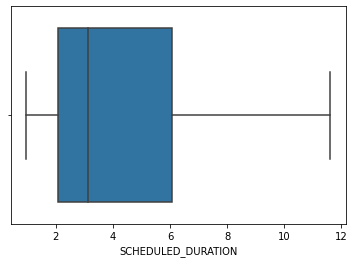

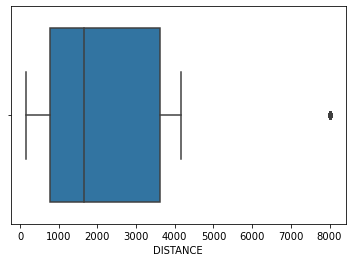

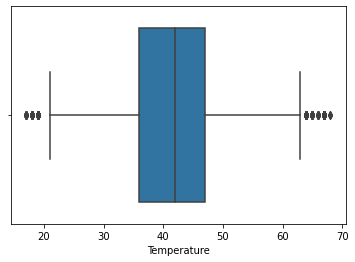

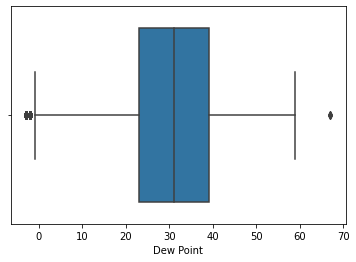

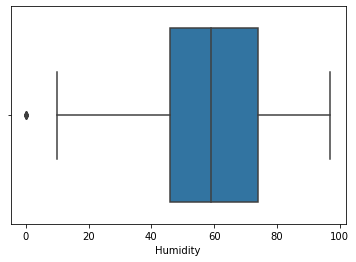

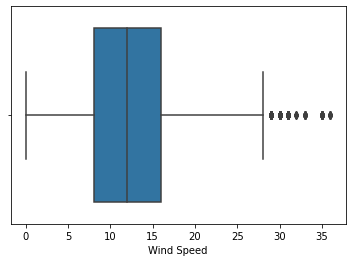

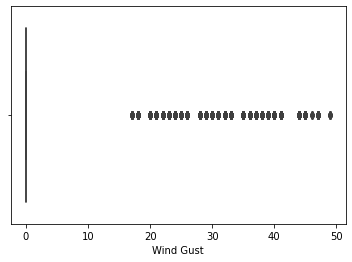

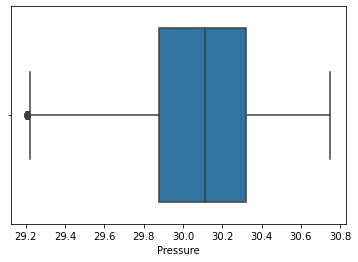

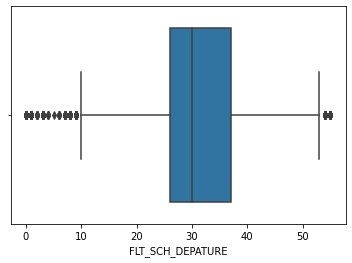

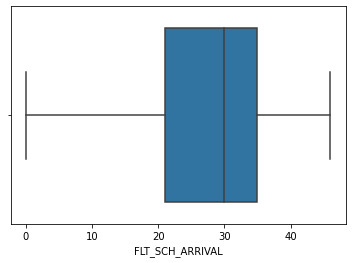

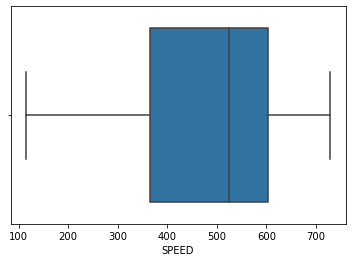

In [247]:
for i in num.columns:
    sns.boxplot(df[i])
    plt.show()

There are so many outlier in the data set, but removing all those will cause us loosing a lot of data. So here we will remove only bottom 5% and top 3% data.

In [248]:
# IQR:
ll=df.quantile(0.03)
ul=df.quantile(0.95)
df1 = df[~ ( ( df > ul)|(df < ll) ).any(axis=1)]  

In [249]:
num1 = df1.select_dtypes(exclude = 'object')
num1.columns

Index(['SCHEDULED_DURATION', 'DISTANCE', 'Temperature', 'Dew Point',
       'Humidity', 'Wind Speed', 'Wind Gust', 'Pressure', 'FLT_SCH_DEPATURE',
       'FLT_SCH_ARRIVAL', 'SPEED'],
      dtype='object')

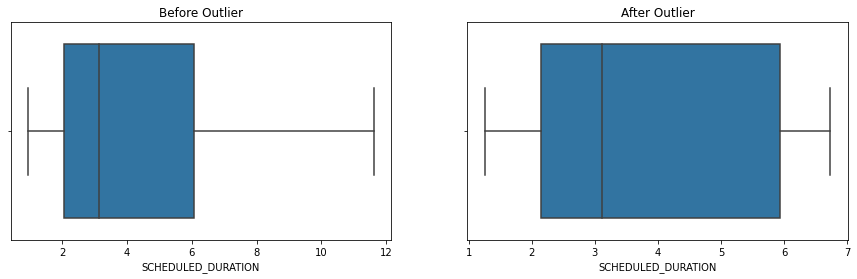

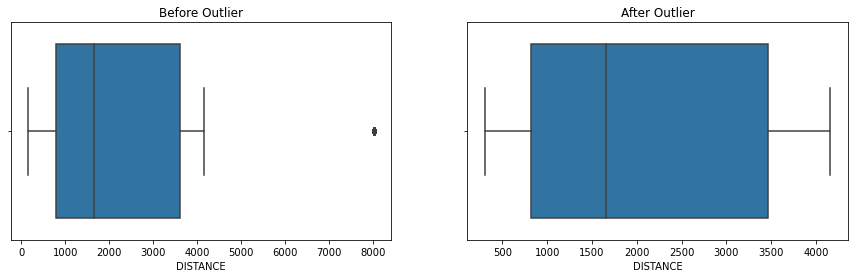

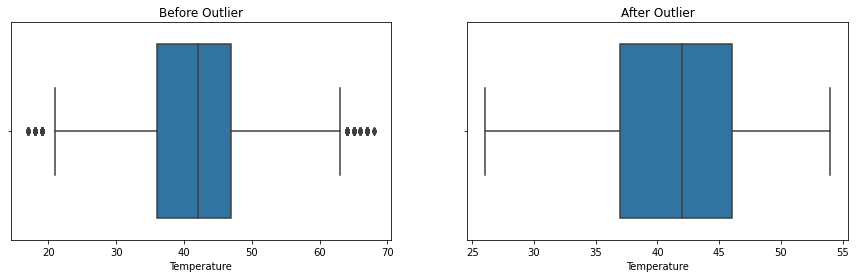

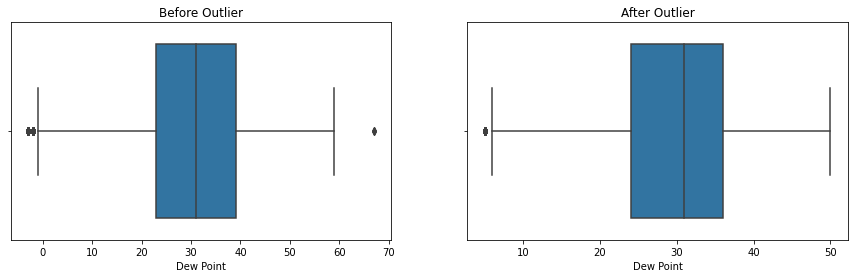

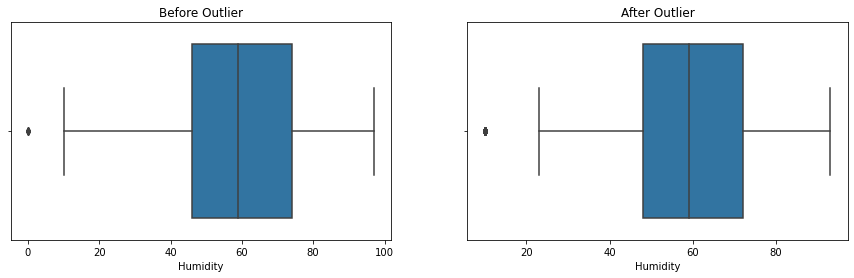

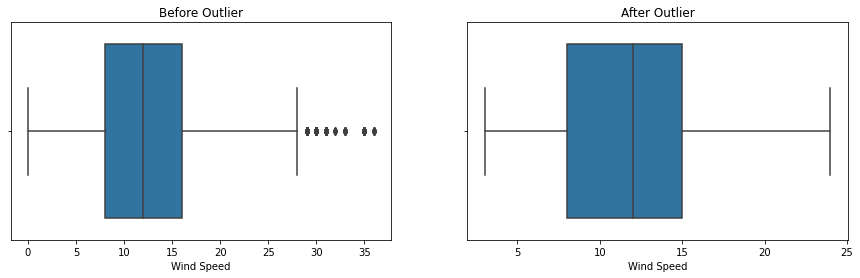

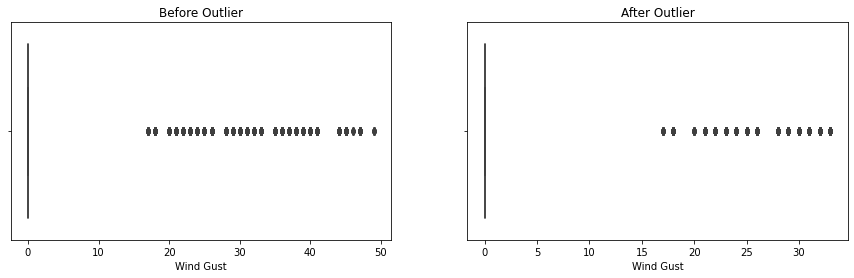

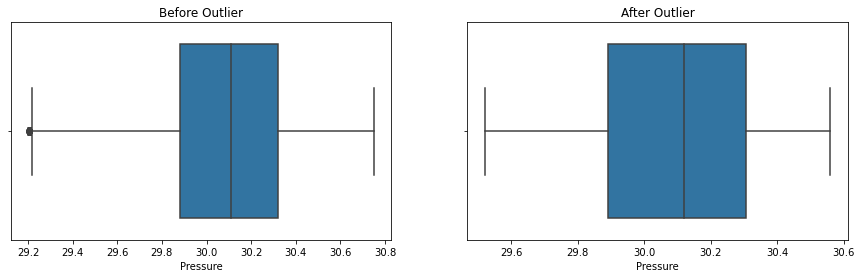

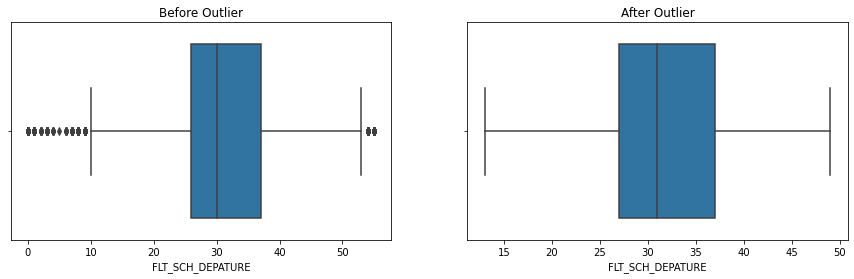

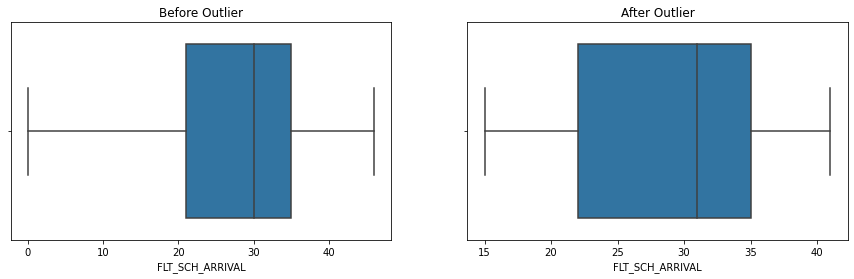

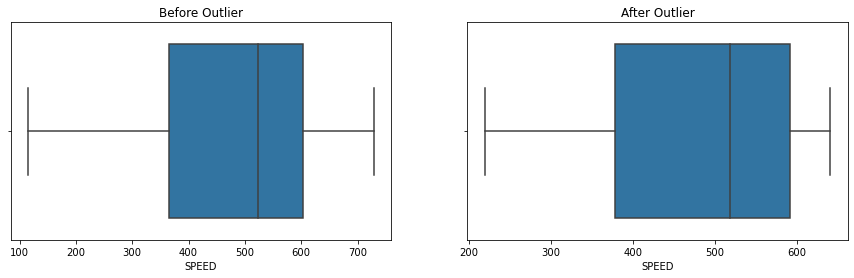

In [250]:
for i in num1.columns:
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.title('Before Outlier')
    sns.boxplot(df[i])
    plt.subplot(122)
    plt.title('After Outlier')
    sns.boxplot(df1[i])
    plt.show()

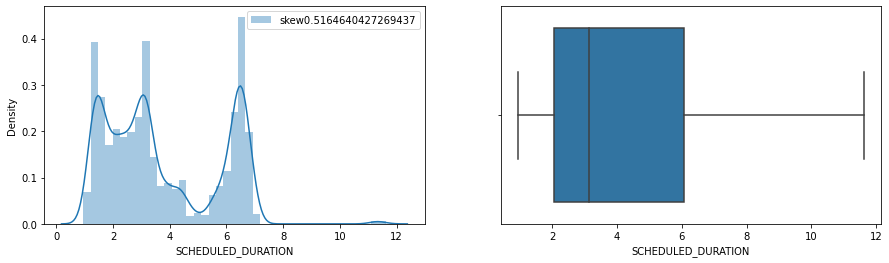

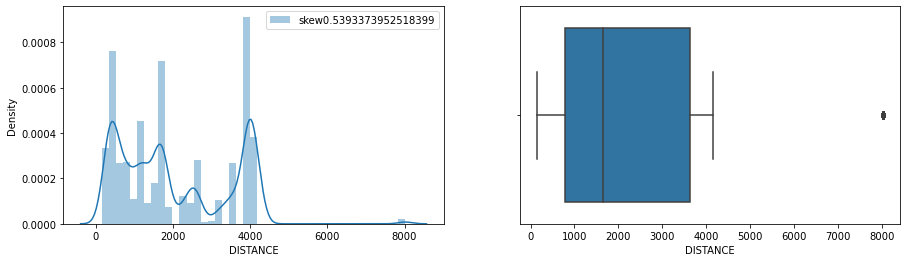

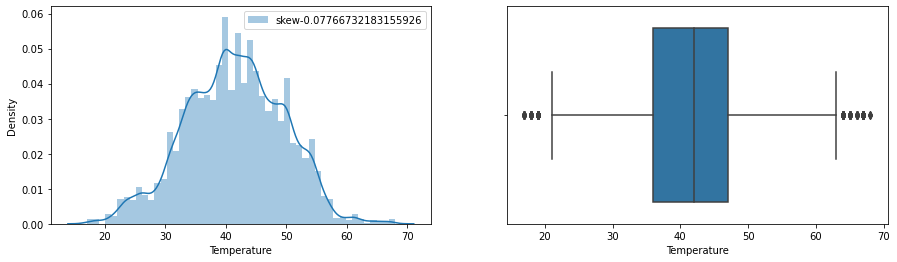

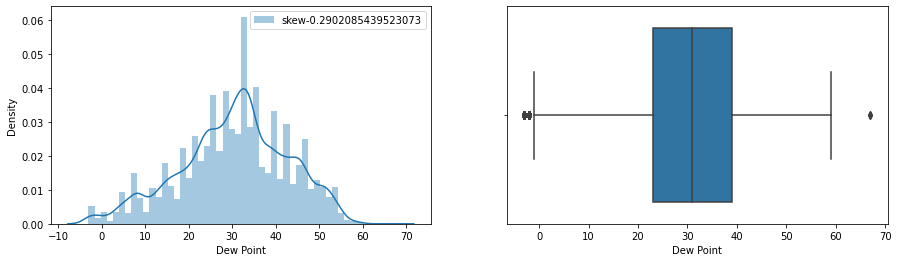

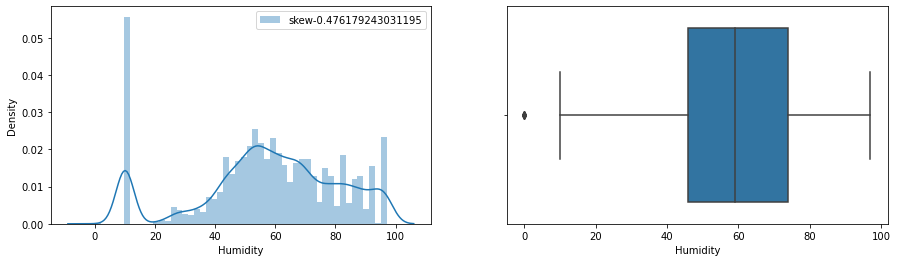

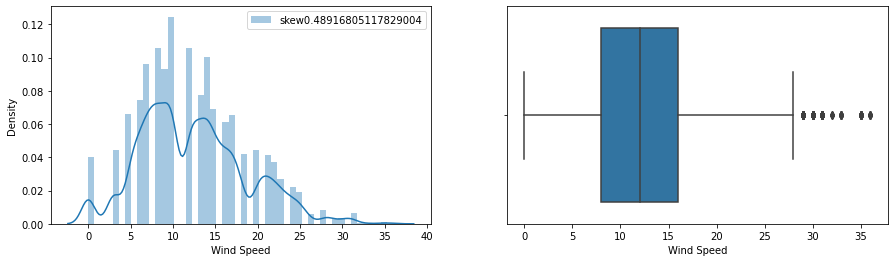

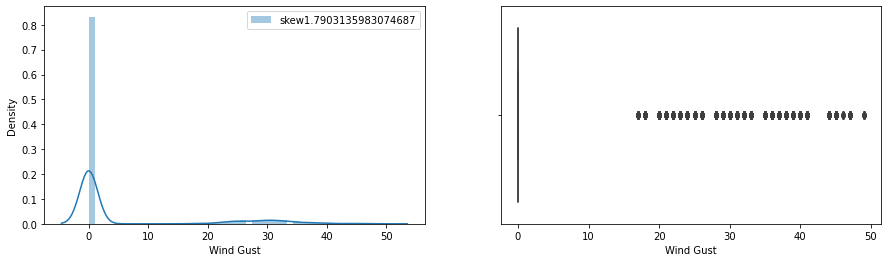

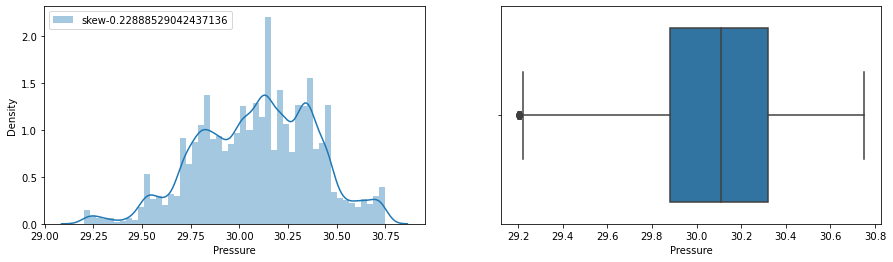

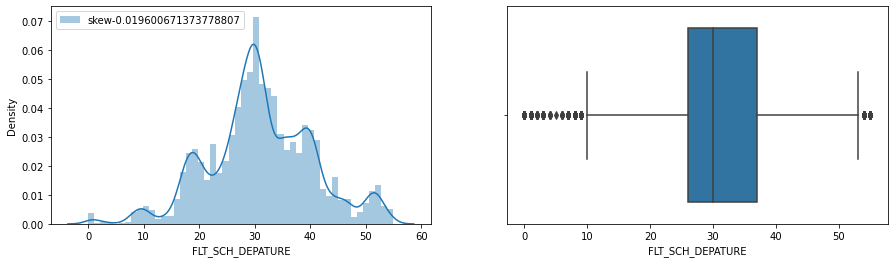

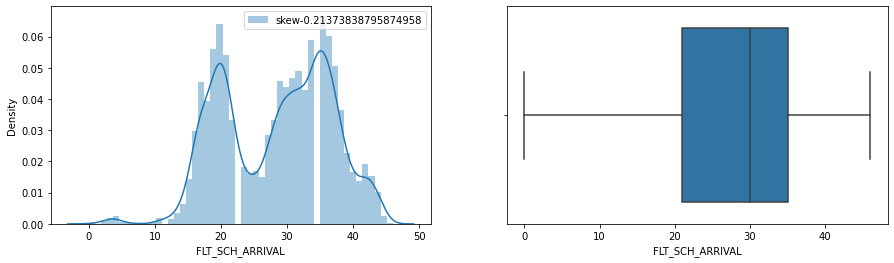

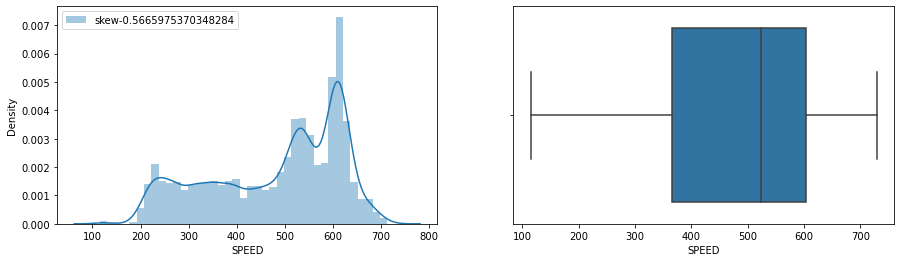

In [251]:
for i in num1.columns:
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    sns.distplot(df[i],label='skew'+str(df[i].skew()))
    plt.legend()
    plt.subplot(122)
    sns.boxplot(df[i])
    plt.show()

 Most of the Outliers are removed from the dataset

In [252]:
df1.head()

,DAY_OF_WEEK,CARRIER_CODE,DEST,DEP_DELAY,SCHEDULED_DURATION,DISTANCE,SCHEDULED_DEPARTURE,ACTUAL_DEPATURE,SCHEDULED_ARRIVAL,Temperature,...,Wind Speed,Wind Gust,Pressure,Condition,FLT_SCH_DEPATURE,FLT_SCH_ARRIVAL,TAXI_OUT,SPEED,Region,FLIGHT_TRAFFIC
15,5,DL,SFO,EARLY,6.516667,4161.75324,Morning,Morning,Morning,47,...,24,29,30.0,Fair / Windy,17,21,L,638.632211,West,Medium
16,5,DL,SLC,EARLY,5.350000,3202.58660,Morning,Morning,Morning,47,...,24,29,30.0,Fair / Windy,17,21,H,598.614318,West,Medium
17,5,DL,BOS,EARLY,1.366667,300.94658,Morning,Morning,Morning,47,...,24,29,30.0,Fair / Windy,17,21,L,220.204815,North East,Medium
19,5,B6,SAV,EARLY,2.383333,1155.50612,Morning,Morning,Morning,47,...,24,29,30.0,Fair / Windy,17,21,L,484.827743,South,Medium
21,5,B6,ATL,ONTIME,2.566667,1223.09840,Morning,Morning,Morning,47,...,24,29,30.0,Fair / Windy,17,21,L,476.531844,South,Medium


#### Creating a new Dataset

In [253]:
df1.to_csv('Taxi_out_processed.csv')